In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import random
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import PowerTransformer
from scipy import stats
from unidecode import unidecode
from sklearn.metrics import mean_squared_error
from scipy.stats import chi2_contingency
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer, IterativeImputer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from datasets import load_dataset
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.kernel_approximation import Nystroem
from sklearn.linear_model import BayesianRidge, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.pipeline import make_pipeline

In [2]:
# Load the dataset without missing values
dataset_cyclists = load_dataset('csv', data_files='dataset/df_cyclists_no_missing.csv')
dataset_races = load_dataset('csv', data_files='dataset/df_races_no_missing.csv')

# Convert to pandas DataFrames
df_cyclists = dataset_cyclists['train'].to_pandas()
df_races = dataset_races['train'].to_pandas()

In [3]:
df_cyclists.head()

,_url,name,birth_year,weight,height,nationality
0,bruno-surra,Bruno Surra,1964.0,70.057068,187.223027,Italy
1,gerard-rue,Gérard Rué,1965.0,74.000000,182.000000,France
2,jan-maas,Jan Maas,1996.0,69.000000,189.000000,Netherlands
3,nathan-van-hooydonck,Nathan Van Hooydonck,1995.0,78.000000,192.000000,Belgium
4,jose-felix-parra,José Félix Parra,1997.0,55.000000,171.000000,Spain


In [4]:
df_races.head()

,_url,name,points,uci_points,length,climb_total,profile,startlist_quality,date,position,cyclist,cyclist_age,is_tarmac,is_cobbled,is_gravel,cyclist_team,delta
0,tour-de-france/1978/stage-6,Tour de France,100.0,16.0,162000.0,1101.0,1.0,1241.0,1978-07-05 04:02:24,0.0,sean-kelly,22.0,True,False,False,vini-ricordi-pinarello-sidermec-1986,0.0
1,tour-de-france/1978/stage-6,Tour de France,100.0,16.0,162000.0,1101.0,1.0,1241.0,1978-07-05 04:02:24,1.0,gerrie-knetemann,27.0,True,False,False,norway-1987,0.0
2,tour-de-france/1978/stage-6,Tour de France,100.0,16.0,162000.0,1101.0,1.0,1241.0,1978-07-05 04:02:24,2.0,rene-bittinger,24.0,True,False,False,australia-1983,0.0
3,tour-de-france/1978/stage-6,Tour de France,100.0,16.0,162000.0,1101.0,1.0,1241.0,1978-07-05 04:02:24,3.0,joseph-bruyere,30.0,True,False,False,navigare-blue-storm-1993,0.0
4,tour-de-france/1978/stage-6,Tour de France,100.0,16.0,162000.0,1101.0,1.0,1241.0,1978-07-05 04:02:24,4.0,sven-ake-nilsson,27.0,True,False,False,spain-1991,0.0


# Creating novel features

Create Body Mass Index from height and weight

In [5]:
df_cyclists['BMI'] = df_cyclists['weight'] / (df_cyclists['height'] / 100) ** 2
df_cyclists['BMI'].head()

0    19.986347
1    22.340297
2    19.316369
3    21.158854
4    18.809206
Name: BMI, dtype: float64

Create form consistency metric: avg_position_last_n_races that captures consistency  (based on recent race positions)

In [6]:
# Make the position an integer
df_races["position"] = df_races["position"].astype(int)

# Group by 'cyclist' and aggregate 'position' into a list
cyclist_positions = df_races.groupby('cyclist')['position'].apply(list).reset_index()

# Rename the column for clarity
cyclist_positions.rename(columns={'position': 'positions_per_race'}, inplace=True)

# Display the result
cyclist_positions


,cyclist,positions_per_race
0,aad-van-den-hoek,"[84, 83, 0, 133, 94, 61, 112, 99, 11, 79, 86, ..."
1,aaron-gate,"[135, 106, 42, 142, 22, 110, 167, 61, 127, 146..."
2,aaron-kemps,"[137, 115, 142, 24, 76, 19, 100, 15, 65, 1, 11..."
3,aaron-olsen,"[145, 163, 130, 136, 160, 129, 84, 155, 115, 6..."
4,aaron-van-poucke,"[36, 93, 101, 91, 53, 135, 99]"
...,...,...
6089,zenon-jaskula,"[112, 73, 35, 117, 42, 23, 9, 10, 74, 63, 138,..."
6090,zhandos-bizhigitov,"[169, 90, 82, 64, 109, 172, 97, 164, 90, 101, ..."
6091,zico-waeytens,"[140, 145, 124, 140, 99, 28, 154, 169, 140, 16..."
6092,zoran-klemencic,"[19, 170, 128, 4, 161, 179, 126, 4, 6, 15, 4, ..."


## Compute avg number of races per cyclist to estimate n parameter
It is then inserted in cyclist database to have one value per cyclist in one row

In [7]:
# Group by 'cyclist' and count the number of races each cyclist participated in
race_counts_per_cyclist = df_races.groupby('cyclist').size()

# Calculate the average number of races per cyclist
avg_races_per_cyclist = race_counts_per_cyclist.mean()

print("Average number of races per cyclist:", avg_races_per_cyclist)

Average number of races per cyclist: 96.78585493928455


In [8]:
# Convert date into right format removing noisy time (also done in the first notebook but for now REDO)
df_races['date'] = df_races['date'].str.split(' ').str[0]
df_races['date'] = pd.to_datetime(df_races['date'], format='%Y-%m-%d')

# new column year
df_races['year'] = df_races['date'].dt.year

# Sort data by cyclist and date to ensure the most recent races are considered in order
tmp = df_races.sort_values(by=['cyclist', 'date'])

# Define the number of recent races to consider for the average position
n = avg_races_per_cyclist.astype(int)

# Calculate the rolling average of 'position' for each cyclist based on the last `n` races
# min_periods parameter ensures that a cyclist does not have n races, the ones avaiable are used to the calculation
df_races['avg_position_last_n_races'] = tmp.groupby('cyclist')['position'].rolling(window=n, min_periods=1).mean().reset_index(level=0, drop=True)

# Extract the final avg_position_last_n_races for each cyclist in df_races
df_avg_position = df_races.groupby('cyclist')['avg_position_last_n_races'].last().reset_index()

# Merge with df_cyclists based on matching columns
df_cyclists = df_cyclists.merge(df_avg_position, left_on='_url', right_on='cyclist', how='left')

# Step 4: Drop redundant columns 
df_cyclists = df_cyclists.drop(columns=['cyclist'])
df_races = df_races.drop(columns=['avg_position_last_n_races'])

# Display the updated df_cyclists with the new column
df_cyclists.head()

,_url,name,birth_year,weight,height,nationality,BMI,avg_position_last_n_races
0,bruno-surra,Bruno Surra,1964.0,70.057068,187.223027,Italy,19.986347,110.000000
1,gerard-rue,Gérard Rué,1965.0,74.000000,182.000000,France,22.340297,64.302083
2,jan-maas,Jan Maas,1996.0,69.000000,189.000000,Netherlands,19.316369,91.631579
3,nathan-van-hooydonck,Nathan Van Hooydonck,1995.0,78.000000,192.000000,Belgium,21.158854,92.280000
4,jose-felix-parra,José Félix Parra,1997.0,55.000000,171.000000,Spain,18.809206,69.166667


# Race difficulty 
From climb total and profile we create this metric. It is weighted since profile are values from 1 to 5, acting as weights.
We normalize it, creating a score in the range [0,1], because if we have a weights of 1, the product will result in a redundant information equal to climb_total

In [9]:
# Convert profile as an integer
df_races["profile"] = df_races["profile"].astype(int)

In [10]:
# Compute Race Difficulty  
df_races['race_difficulty'] = df_races['climb_total'] * df_races['profile'] 

# Normalize in the range [0,1]
df_races['race_difficulty'] = (df_races['race_difficulty'] - df_races['race_difficulty'].min()) / \
                                     (df_races['race_difficulty'].max() - df_races['race_difficulty'].min())


# Display race_difficulty
df_races[['name', 'climb_total', 'profile', 'race_difficulty']]

,name,climb_total,profile,race_difficulty
0,Tour de France,1101.0,1,0.031519
1,Tour de France,1101.0,1,0.031519
2,Tour de France,1101.0,1,0.031519
3,Tour de France,1101.0,1,0.031519
4,Tour de France,1101.0,1,0.031519
...,...,...,...,...
589808,Giro d'Italia,60.0,1,0.001663
589809,Giro d'Italia,60.0,1,0.001663
589810,Giro d'Italia,60.0,1,0.001663
589811,Giro d'Italia,60.0,1,0.001663


# Team strength 
Groups the data by each team. Then, compute the sum or the average of startlist_quality values for all cyclists within the same team. The sum represents the total strength of the team, while the average gives a sense of the average strength per cyclist in the team. We know that the startlist_quality might vary from race to race, as different races might have different levels of competition or difficulty. Thus, if a team participates in both high-quality and low-quality races within the same period, the team strength will aggregate both types of races.

Here, the strength is calculated first all over the years. This could make sense because teams are ofter historical. So, even if they changed over 20 years, an overall statistic on the importance/famousness of that team can be useful.

In addition, we can divide the years in 70's, 80's, 90's and from 2000-2023 and calculate the strength for each team but in different cycling years. This information will be stored in another dataset called team_cyclist_strength

In [11]:
df_races["year"].unique()

array([1978, 2016, 2019, 1999, 2022, 2017, 2018, 1981, 1994, 1984, 1991,
       1980, 2015, 2004, 1997, 2005, 1993, 2021, 1983, 1988, 2009, 1985,
       2012, 2000, 1998, 2014, 2011, 2010, 2002, 2020, 2007, 1996, 1986,
       1987, 1989, 2013, 2008, 1990, 1992, 1970, 2001, 1982, 1977, 2006,
       1979, 1995, 2023, 1975, 2003, 1976, 1973, 1974, 1971, 1972],
      dtype=int32)

In [12]:
print(df_races["year"].min())
print(df_races["year"].max())

# anni 70
# anni 80
# anni 90
# anni 2000

1970
2023


In [13]:
# Step 1: Group by 'cyclist_team' and get the unique years for each team
team_years = df_races.groupby('cyclist_team')['year'].unique().reset_index()

# Step 2: Sort the years in ascending order for each team
team_years['year'] = team_years['year'].apply(lambda years: sorted(years))

# Step 3: Display the results
team_years[['cyclist_team', 'year']]

,cyclist_team,year
0,ag2r-prevoyance-2001,"[1970, 1971, 1972, 1973, 1974, 1975, 1976, 197..."
1,atala-1985,"[1970, 1971, 1972, 1973, 1975, 1976, 1977, 197..."
2,atala-campagnolo-1983,"[1970, 1971, 1972, 1976, 1977, 1978, 1979, 198..."
3,atala-ofmega-1988,"[1970, 1971, 1976, 1977, 1978, 1979, 1980, 198..."
4,australia-1983,"[1970, 1971, 1973, 1974, 1975, 1976, 1977, 197..."
...,...,...
86,united-states-1998,"[1970, 1971, 1973, 1974, 1975, 1976, 1977, 197..."
87,ville-de-charleroi-new-systems-2000,"[1970, 1971, 1972, 1973, 1974, 1975, 1976, 197..."
88,vini-fantini-2013,"[1970, 1971, 1972, 1973, 1975, 1976, 1977, 197..."
89,vini-ricordi-pinarello-sidermec-1986,"[1970, 1971, 1972, 1974, 1975, 1976, 1977, 197..."


Here, there are some teams called, for example, "sport-vlaanderen-baloise-2021". This might be a team that raced in the 1980s but carried the sponsorship or team name "Sport Vlaanderen Baloise" starting in 2021. So we leave this way because probably the dataset represents older teams with new name

# For all years (historical)
Stored directly in df_races dataset

In [14]:
# Calculate the average of startlist_quality per team
df_races['team_avg_strength'] = df_races.groupby('cyclist_team')['startlist_quality'].transform('mean')

# Display the result 
df_races[['cyclist_team', 'year', 'team_avg_strength']].drop_duplicates()

,cyclist_team,year,team_avg_strength
0,vini-ricordi-pinarello-sidermec-1986,1978,1111.843112
1,norway-1987,1978,1120.898942
2,australia-1983,1978,1090.682310
3,navigare-blue-storm-1993,1978,1111.515789
4,spain-1991,1978,1096.743157
...,...,...,...
589434,atala-ofmega-1988,1976,1123.998225
589435,austria-1991,1976,1127.898975
589454,team-giant-shimano-2014,1976,1082.809066
589467,japan-2008,1976,1122.031869


# Done by year (new dataset)

In [15]:
# Create a new column for the time period (decades)
def get_period(year):
    if 1970 <= year <= 1979:
        return '1970s'
    elif 1980 <= year <= 1989:
        return '1980s'
    elif 1990 <= year <= 1999:
        return '1990s'
    elif 2000 <= year <= 2023:
        return '2000-2023'
    else:
        return 'Before 1970'

# Create decades period column of rafces in the dataset
df_races['period'] = df_races['year'].apply(get_period)

# Compute team strength (sum) and average startlist_quality for each team and period
team_strength = df_races.groupby(['cyclist_team', 'period'])['startlist_quality'].agg(['mean']).reset_index()

# Rename the columns to make it clear
team_strength.rename(columns={'mean': 'team_avg_strength'}, inplace=True)

# Display the new dataset with team name, period, and computed strength
team_strength

# Save it
#team_strength.to_csv('team_avg_trength_per_period.csv', index=False)

,cyclist_team,period,team_avg_strength
0,ag2r-prevoyance-2001,1970s,922.568966
1,ag2r-prevoyance-2001,1980s,1291.623236
2,ag2r-prevoyance-2001,1990s,1341.826440
3,ag2r-prevoyance-2001,2000-2023,1050.248118
4,atala-1985,1970s,852.450000
...,...,...,...
358,vini-ricordi-pinarello-sidermec-1986,2000-2023,1049.123267
359,watney-avia-1972,1970s,832.346667
360,watney-avia-1972,1980s,1345.335065
361,watney-avia-1972,1990s,1280.498969


Here, we can gain useful insights for each team. For example, we can infer that some teams has become more powerful over the years. But this is reasonable or it is due to some inconsistency in the data ? We plot some distribution to give us an idea on how teas grows over the years

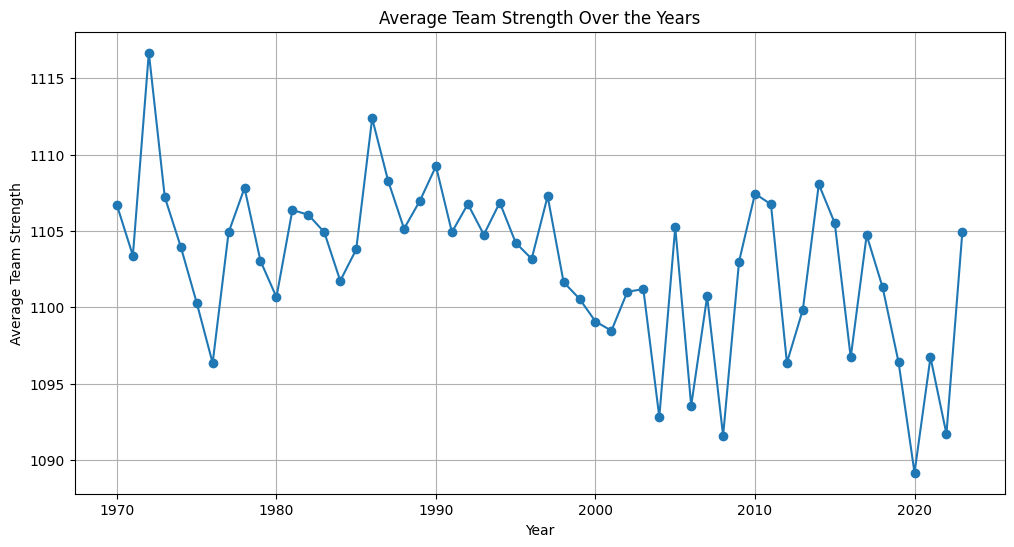

In [20]:
# Group by year and calculate the average strength for each year
yearly_avg_strength = df_races.groupby('year')['team_avg_strength'].mean().reset_index()

# Plot the trend of team average strength over the years
plt.figure(figsize=(12, 6))
plt.plot(yearly_avg_strength['year'], yearly_avg_strength['team_avg_strength'], marker='o', linestyle='-')
plt.title('Average Team Strength Over the Years')
plt.xlabel('Year')
plt.ylabel('Average Team Strength')
plt.grid(True)
plt.show()

Seems that over the years, in the 70's there were better cyclists

# Examine the Correlation Between startlist_quality and years

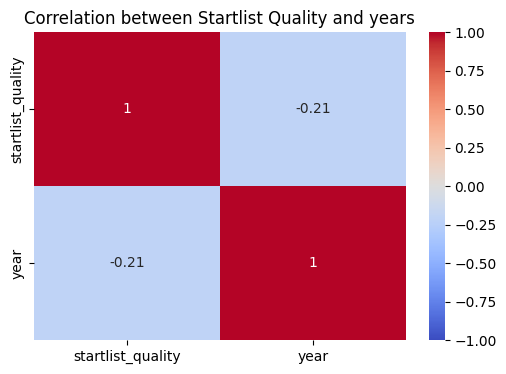

In [21]:
# Compute the correlation between startlist_quality and race difficulty
correlation = df_races[['startlist_quality', 'year']].corr()

# Plot
plt.figure(figsize=(6, 4))
seaborn.heatmap(correlation, annot=True, cmap='coolwarm', cbar=True, vmin=-1, vmax=1)
plt.title('Correlation between Startlist Quality and years')
plt.show()

As expected, there is a little correlation between them, with can reflect the plot did before. We have also to consider that a team might appear stronger over time simply because they have better sponsorship, and this could be reflected in the startlist_quality metric over that year.

# Bias of avg strength: there is a Trade off

- With a simple Mean (No Weighting) we treat all races equally, regardless of prestige. This reduces the prestige bias but could result in misleadingly high strength values for teams that primarily compete in easier, low-prestige events.

- With a Weighted Mean (using points as weights) we emphasizes high-prestige races, potentially better reflecting the strength of teams that regularly compete in top-tier events. However, it may undervalue teams that race mainly in low-prestige events

# Cyclist Experience